In [1]:
# Importing required libraries
import numpy as np
import pandas as pd

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [3]:
# Loading data
df = pd.read_csv('dataset.csv')

In [4]:
# Combine date and time into a single timestamp
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

In [5]:
# Sorting
df = df.sort_values(by=['SystemCodeNumber', 'Timestamp']).reset_index(drop=True)

In [6]:
# PARAMETERS
alpha_momentum = 2.0
min_price = 5.0
max_price = 20.0
base_price = 10.0

In [7]:
# Creating a new column for the dynamic pricing.
df['Price_Momentum'] = None

In [51]:
for lot_id, group in df.groupby('SystemCodeNumber'):
  group = group.sort_values(by='Timestamp').reset_index()

  # Change in occupancy normalized by capacity of the lot
  occ_delta = group['Occupancy'].diff().fillna(0) / group['Capacity'].iloc[0]

  # MOMENTUM ( Sum of last 3 changes in the occ_delta )
  momentum = occ_delta.rolling(window = 3, min_periods = 1 ).sum()

  # PRICE EVOLUTION
  prices = []
  price = base_price
  for m in momentum:
    price = price + alpha_momentum * m
    price = price + 1.1 * np.tanh(m)
    price = min(max(price, min_price), max_price)
    prices.append(price)

  # Storing the Momentum based price
  df.loc[group['index'], 'Price_Momentum'] = prices

In [52]:
# FINAL Result
df['Price_Momentum'] = df['Price_Momentum'].astype(float)
df[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity', 'Price_Momentum']].head(10)

,SystemCodeNumber,Timestamp,Occupancy,Capacity,Price_Momentum
0,BHMBCCMKT01,2016-10-04 07:59:00,61,577,10.000000
1,BHMBCCMKT01,2016-10-04 08:25:00,64,577,10.016118
2,BHMBCCMKT01,2016-10-04 08:59:00,80,577,10.118184
3,BHMBCCMKT01,2016-10-04 09:32:00,107,577,10.365140
4,BHMBCCMKT01,2016-10-04 09:59:00,150,577,10.825981
5,BHMBCCMKT01,2016-10-04 10:26:00,177,577,11.345402
6,BHMBCCMKT01,2016-10-04 10:59:00,219,577,11.944494
7,BHMBCCMKT01,2016-10-04 11:25:00,247,577,12.463915
8,BHMBCCMKT01,2016-10-04 11:59:00,259,577,12.903426
9,BHMBCCMKT01,2016-10-04 12:29:00,266,577,13.155741


In [53]:
# Downloading the RESULTANT csv file
df.to_csv("momentum_pricing_model.csv", index=False)

from google.colab import files
files.download("momentum_pricing_model.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# MODEL VISUALIZATION ( Using Bokeh Plot )
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource

output_notebook()

lots = df['SystemCodeNumber'].unique()
figures = []

for lot in lots:
    lot_df = df[df['SystemCodeNumber'] == lot].sort_values('Timestamp')
    source = ColumnDataSource(data={
        'x': lot_df['Timestamp'],
        'y': lot_df['Price_Momentum']
    })

    p = figure(title=lot, x_axis_type='datetime', width=350, height=250)
    p.line('x', 'y', source=source, line_width=2)
    figures.append(p)

# Organize into grid: 3 plots per row
grid = gridplot([figures[i:i+3] for i in range(0, len(figures), 3)])
show(grid)

In [ ]:
# Since we are not able to simulate the real time data on colab, so ,
# I'm creating a local real time dashboard of BOKEH Plot which can be run locally.

dashboard_code = """
from bokeh.plotting import figure, curdoc
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
import pandas as pd

# --- CONFIG ---
data_path = "momentum_pricing_model.csv"
alpha = 2.0
min_price = 5.0
max_price = 20.0
base_price = 10.0

# --- LOAD DATA ---
df = pd.read_csv(data_path)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['SystemCodeNumber', 'Timestamp']).reset_index(drop=True)

lots = df['SystemCodeNumber'].unique()
print("✅ Script loaded, lots found:", lots)

# --- SETUP LOTS ---
lots = df['SystemCodeNumber'].unique()
lot_sources = {}
lot_figures = {}
lot_indices = {}

for lot in lots:
    lot_df = df[df['SystemCodeNumber'] == lot].copy()
    lot_df = lot_df.sort_values('Timestamp').reset_index(drop=True)

    source = ColumnDataSource(data={'x': [], 'y': []})
    p = figure(title=lot, x_axis_type='datetime', width=400, height=250)
    p.line('x', 'y', source=source, line_width=2)
    p.circle('x', 'y', source=source, size=3)

    lot_sources[lot] = {'data': lot_df, 'source': source, 'price': base_price}
    lot_figures[lot] = p
    lot_indices[lot] = 0

# --- CALLBACK FUNCTION ---
def update():
    for lot in lots:
        i = lot_indices[lot]
        lot_data = lot_sources[lot]['data']
        if i < len(lot_data):
            if i >= 3:
                occ_delta = lot_data['Occupancy'].diff().fillna(0) / lot_data['Capacity'].iloc[0]
                momentum = occ_delta.iloc[i-2:i+1].sum()
                new_price = lot_sources[lot]['price'] + alpha * momentum
                new_price = min(max(new_price, min_price), max_price)
            else:
                new_price = base_price

            ts = lot_data['Timestamp'].iloc[i]

            new_point = {'x': [ts], 'y': [new_price]}
            lot_sources[lot]['source'].stream(new_point)
            lot_sources[lot]['price'] = new_price
            lot_indices[lot] += 1

# --- LAYOUT ---
plots = list(lot_figures.values())
rows = [plots[i:i+3] for i in range(0, len(plots), 3)]
layout = gridplot(rows)

curdoc().add_root(layout)
curdoc().add_periodic_callback(update, 300)
"""

# Save it to file
with open("real_time_dashboard.py", "w") as f:
    f.write(dashboard_code)

In [ ]:
from google.colab import files
files.download("real_time_dashboard.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

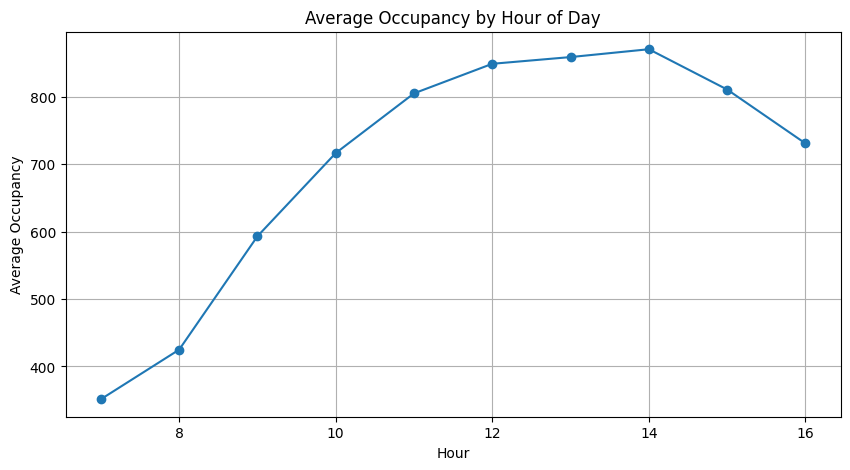

In [55]:
# Running this code just to check the hour based occupancy

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour

# Average occupancy per hour across all lots
avg_occ_by_hour = df.groupby('Hour')['Occupancy'].mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(avg_occ_by_hour.index, avg_occ_by_hour.values, marker='o')
plt.title('Average Occupancy by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Occupancy')
plt.grid(True)
plt.show()